# Vistazo de librerías

In [23]:
import feast
import dagshub
import mlflow
import pandas as pd
from feast import FeatureStore
from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource
)
from feast.types import Float32, Float64, Int64, String
import uuid
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score




from procesamientos import (
    FeatureProcessor,
    GuardadoFeature,
    ExperimientoClasificador,
    expermientoepsilon,
    Metricsdeploy,
    UnsupervisedProcessor,
    ProcesoMLFLOW
)
#from procesamientos import

ModuleNotFoundError: No module named 'xgboost'

# Datasets que encontré

In [3]:
Stresslevel =  pd.read_csv("../data/Stress_Dataset.csv")
vehiculos =  pd.read_csv("../data/electric_vehicles_spec_2025.csv")
stress = pd.read_csv('../data/StressLevelDataset.csv')
ai_job = pd.read_csv('../data/ai_job_trends_dataset.csv')
restaurants = pd.read_csv('../data/Bengaluru_Restaurants.csv')

## Desarrollo

In [4]:
Stresslevel['Which type of stress do you primarily experience?'].unique()

array(['Eustress (Positive Stress) - Stress that motivates and enhances performance.',
       'No Stress - Currently experiencing minimal to no stress.',
       'Distress (Negative Stress) - Stress that causes anxiety and impairs well-being.'],
      dtype=object)

In [5]:
Stresslevel['Which type of stress do you primarily experience?'] = Stresslevel['Which type of stress do you primarily experience?'].replace({
    'Eustress (Positive Stress) - Stress that motivates and enhances performance.': 'Eustress',
    'No Stress - Currently experiencing minimal to no stress.': 'No stress',
    'Distress (Negative Stress) - Stress that causes anxiety and impairs well-being.': 'Distress'
})

In [6]:
Stresslevel


,Gender,Age,Have you recently experienced stress in your life?,Have you noticed a rapid heartbeat or palpitations?,Have you been dealing with anxiety or tension recently?,Do you face any sleep problems or difficulties falling asleep?,Have you been dealing with anxiety or tension recently?.1,Have you been getting headaches more often than usual?,Do you get irritated easily?,Do you have trouble concentrating on your academic tasks?,...,Are you facing any difficulties with your professors or instructors?,Is your working environment unpleasant or stressful?,Do you struggle to find time for relaxation and leisure activities?,Is your hostel or home environment causing you difficulties?,Do you lack confidence in your academic performance?,Do you lack confidence in your choice of academic subjects?,Academic and extracurricular activities conflicting for you?,Do you attend classes regularly?,Have you gained/lost weight?,Which type of stress do you primarily experience?
0,0,20,3,4,2,5,1,2,1,2,...,3,1,4,1,2,1,3,1,2,Eustress
1,0,20,2,3,2,1,1,1,1,4,...,3,2,1,1,3,2,1,4,2,Eustress
2,0,20,5,4,2,2,1,3,4,2,...,2,2,2,1,4,1,1,2,1,Eustress
3,1,20,3,4,3,2,2,3,4,3,...,1,1,2,1,2,1,1,5,3,Eustress
4,0,20,3,3,3,2,2,4,4,4,...,2,3,1,2,2,4,2,2,2,Eustress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,0,21,3,4,2,3,5,1,5,4,...,2,3,3,3,4,1,2,2,2,Eustress
839,1,19,3,2,1,2,2,1,2,3,...,1,1,1,3,2,1,2,3,1,No stress
840,1,19,4,4,3,4,3,2,2,3,...,2,2,2,2,3,1,4,5,3,Eustress
841,0,20,5,4,3,4,3,4,4,4,...,2,2,1,4,3,5,4,5,1,Eustress


In [11]:
Stresslevel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 27 columns):
 #   Column                                                                Non-Null Count  Dtype 
---  ------                                                                --------------  ----- 
 0   Id                                                                    843 non-null    int64 
 1   Gender                                                                843 non-null    int64 
 2   Age                                                                   843 non-null    int64 
 3   Have you recently experienced stress in your life?                    843 non-null    int64 
 4   Have you noticed a rapid heartbeat or palpitations?                   843 non-null    int64 
 5   Have you been dealing with anxiety or tension recently?               843 non-null    int64 
 6   Do you face any sleep problems or difficulties falling asleep?        843 non-null    int64 
 7   Have you

# Ensambles clasificación -> procesamientos.py

In [22]:
X, y = Stresslevel.drop(['Id', 'Which type of stress do you primarily experience?'], axis=1), Stresslevel['Which type of stress do you primarily experience?']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)        


In [29]:
mlflow.set_tracking_uri('https://dagshub.com/Marquinhos9873/mle2.mlflow')
mlflow.create_experiment("Experimento Prueba mle2 - modulo 2")
mlflow.set_experiment("Experimento Prueba mle2 - modulo 2")


MlflowException: API request to endpoint /api/2.0/mlflow/experiments/create failed with error code 403 != 200. Response body: ''

In [26]:
#ProcesoMLFLOW(uri = 'https://dagshub.com/Marquinhos9873/mle2.mlflow')

 
#Las variables de mayor peso se redimensionan con pca -> columnas = -> great_feature1 = pipe_feature
fp = FeatureProcessor(datos = Stresslevel, name_pipeline = 'pipeline_ensamble', columnas = ['Have you been dealing with anxiety or tension recently?', 'Have you been dealing with anxiety or tension recently?.1', 'Have you noticed a rapid heartbeat or palpitations?', 'Have you noticed a rapid heartbeat or palpitations?', 'Do you face any sleep problems or difficulties falling asleep?', 'Do you feel overwhelmed with your academic workload?', 'Do you have trouble concentrating on your academic tasks?', 'Do you get irritated easily?'], components = 2)
#Promedio general de todos los factores
feature_table_processed = fp.run(columnas_promedio = Stresslevel.drop(['Which type of stress do you primarily experience?', 'Age', 'Id', 'Gender'], axis=1))
fp.write_feature_table(filepath = '../feast_Service/feature_store_general/feature_repo')                      
                      
#written_feature_table = pd.read_parquet('../') 
#written_feature_table.head()

experimento = ExperimentoClasificador()
pipeline_clasf_experimento = experimento.experiment_definition(X_train, X_test, y_train, y_test)
mlflow.log_artifact(pipeline_clasf_experimento)

# Modo directo (usa Random Forest sin preguntar)
#    modelo_pipeline = exp.experiment_definition(X_train, X_test, y_train, y_test, model="1")

#Triggers input
#procesamientos as proce

                      



"exogena -> Have you gained/lost weight?"

MlflowException: API request to https://dagshub.com/Marquinhos9873/mle2.mlflow/api/2.0/mlflow/experiments/get failed with exception HTTPSConnectionPool(host='dagshub.com', port=443): Max retries exceeded with url: /Marquinhos9873/mle2.mlflow/api/2.0/mlflow/experiments/get?experiment_id=None (Caused by ResponseError('too many 500 error responses'))

In [ ]:
pipeline_clasf_exp = experiment_definition(X_train, X_test, y_train, y_test)                     
                      

## Problemas de compatibilidad(creo) entre mi archivo .ipynb y el procesamiento.py







## Problema con mlflow en Ensambles.ipynb

### 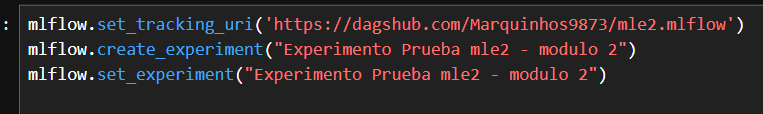
### 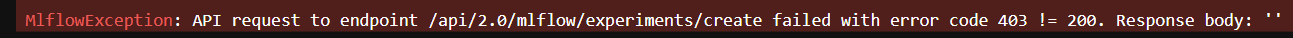
### 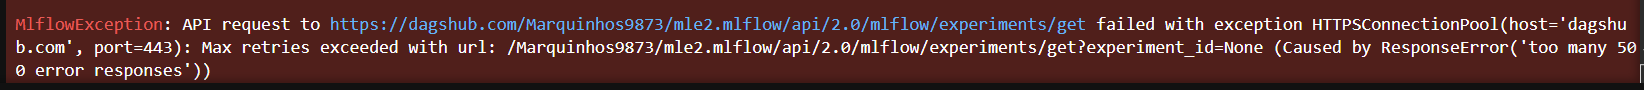

## TS 
### 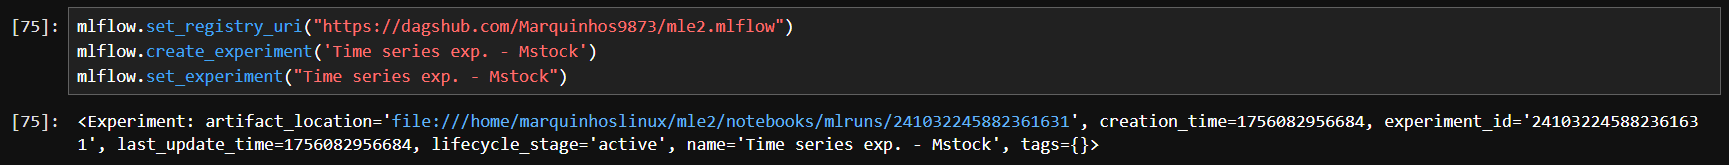





## Problemas de compatibilidad con Serie de tiempo -> arima/pdarima/prophet 
###
###
### 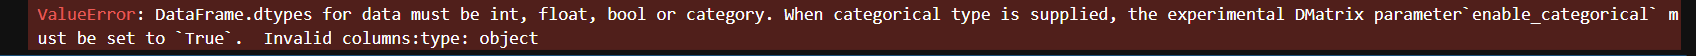


### /usr/bin/python3
### WARNING: Package(s) not found: prophet    / No toma los paquetes instalados via poetry add    


### 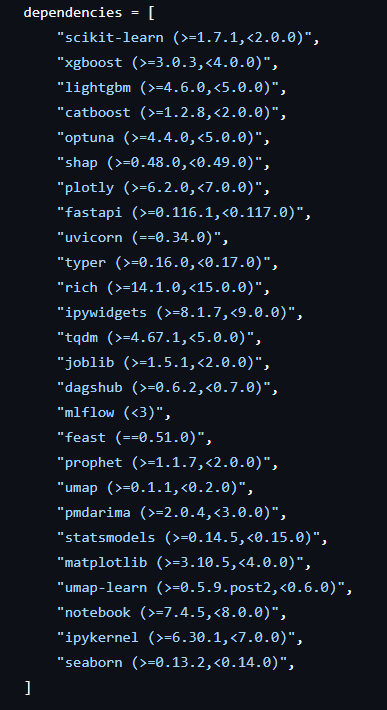 


## Ya lo he corrido como poetry run python procesamientos.py para probarlo dentro del venv de poetry y todo ok, lo quiero importar y:
### 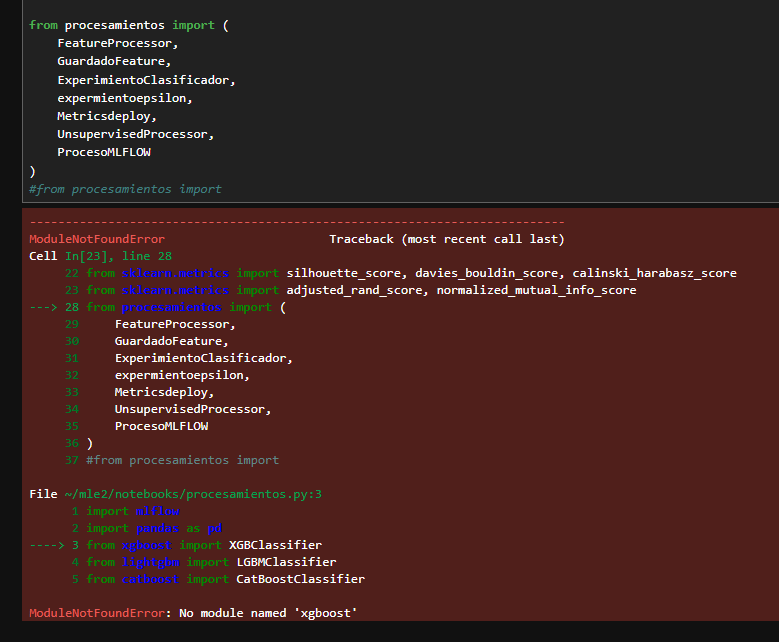
### ya habiendolo descargado con poetry add, igual no ejecuta


## Yo he querido reutilizar el codigo de clases y agregué algunas cosas sobre procesamientos.py 
## Quite loguru porque hubo un inconveniente con el pyproject y al entrar con vim/nano me salía un warning

In [35]:
from xgboost import XGBClassifier


ModuleNotFoundError: No module named 'xgboost'

In [36]:
import sys
print(sys.executable)
#marquinhoslinux@DESKTOP-ERHQBI3:~/mle2$ poetry run which python
#/home/marquinhoslinux/.cache/pypoetry/virtualenvs/mle2-4amom_Hy-py3.11/bin/python

/usr/bin/python3


In [17]:
Stresslevel.info()
'Have you been dealing with anxiety or tension recently? ',
'Have you been dealing with anxiety or tension recently?.1',
'Have you noticed a rapid heartbeat or palpitations? ',
'Do you face any sleep problems or difficulties falling asleep? ',
'Do you feel overwhelmed with your academic workload? ',
'Do you have trouble concentrating on your academic tasks? ',
'Do you get irritated easily?',
'',
'',
"exogena" -> 'Have you gained/lost weight?'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 26 columns):
 #   Column                                                                Non-Null Count  Dtype 
---  ------                                                                --------------  ----- 
 0   Gender                                                                843 non-null    int64 
 1   Age                                                                   843 non-null    int64 
 2   Have you recently experienced stress in your life?                    843 non-null    int64 
 3   Have you noticed a rapid heartbeat or palpitations?                   843 non-null    int64 
 4   Have you been dealing with anxiety or tension recently?               843 non-null    int64 
 5   Do you face any sleep problems or difficulties falling asleep?        843 non-null    int64 
 6   Have you been dealing with anxiety or tension recently?.1             843 non-null    int64 
 7   Have you

In [15]:
stress

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,11,17,0,14,3,1,3,2,2,2,...,3,2,2,2,3,3,2,3,3,1
1096,9,12,0,8,0,3,0,0,0,1,...,4,0,1,1,1,1,3,4,3,2
1097,4,26,0,3,1,2,5,2,2,3,...,4,5,1,4,1,3,1,2,1,0
1098,21,0,1,19,5,3,1,4,3,1,...,1,2,5,1,4,1,4,4,4,2


In [20]:
stress['stress_level'] = stress['stress_level'].replace({
    0: 'Low',
    1: 'Medium',
    2: 'High'
})


In [15]:
stress.insert(0, 'Id', range(1, len(stress) + 1))
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Id                            1100 non-null   int64
 1   anxiety_level                 1100 non-null   int64
 2   self_esteem                   1100 non-null   int64
 3   mental_health_history         1100 non-null   int64
 4   depression                    1100 non-null   int64
 5   headache                      1100 non-null   int64
 6   blood_pressure                1100 non-null   int64
 7   sleep_quality                 1100 non-null   int64
 8   breathing_problem             1100 non-null   int64
 9   noise_level                   1100 non-null   int64
 10  living_conditions             1100 non-null   int64
 11  safety                        1100 non-null   int64
 12  basic_needs                   1100 non-null   int64
 13  academic_performance          110

In [17]:
stress
'anxiety_level',
'self_esteem',
'sleep_quality',
'social_support',
'depression',
'bullying',
'mental_health_history',
#"exogena1" -> 'safety'
#"exogena2" -> 'living_conditions'

('mental_health_history',)

In [21]:
stress

,Id,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,1,14,20,0,11,2,1,2,4,2,...,2,3,2,3,3,2,3,3,2,Medium
1,2,15,8,1,15,5,3,1,4,3,...,2,1,4,1,5,1,4,5,5,High
2,3,12,18,1,14,2,1,2,2,2,...,2,2,3,3,2,2,3,2,2,Medium
3,4,16,12,1,15,4,3,1,3,4,...,2,2,4,1,4,1,4,4,5,High
4,5,16,28,0,7,2,3,5,1,3,...,3,4,3,1,2,1,5,0,5,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,11,17,0,14,3,1,3,2,2,...,3,2,2,2,3,3,2,3,3,Medium
1096,1097,9,12,0,8,0,3,0,0,0,...,4,0,1,1,1,1,3,4,3,High
1097,1098,4,26,0,3,1,2,5,2,2,...,4,5,1,4,1,3,1,2,1,Low
1098,1099,21,0,1,19,5,3,1,4,3,...,1,2,5,1,4,1,4,4,4,High


In [ ]:
X, y = stress.drop(['Id', 'stress_level'], axis=1), stress['stress_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                  

In [28]:
mlflow.set_tracking_uri('https://dagshub.com/Marquinhos9873/mle2.mlflow')
mlflow.create_experiment("Experimento Prueba stress 2 mle2 - modulo 2")
mlflow.set_experiment("Experimento Prueba stress 2 mle2 - modulo 2")


MlflowException: API request to endpoint /api/2.0/mlflow/experiments/create failed with error code 403 != 200. Response body: ''

In [30]:

fp = FeatureProcessor(datos = stress, name_pipeline = 'pipeline_ensamble_stress2', columnas = [
    'anxiety_level', 'self_esteem', 'sleep_quality', 'social_support', 'depression', 'bullying', 'mental_health_history',],
                      components = 2)
fp.run(columnas_promedio = ('Have you been dealing with anxiety or tension recently?', 'Have you been dealing with anxiety or tension recently?.1', 'Have you noticed a rapid heartbeat or palpitations?', 'Have you noticed a rapid heartbeat or palpitations?', 'Do you face any sleep problems or difficulties falling asleep?', 'Do you feel overwhelmed with your academic workload?', 'Do you have trouble concentrating on your academic tasks?', 'Do you get irritated easily?'))
fp.witre_feature_table('../feast_Service/feature_store_general/feature_repo')  

pipeline_stress_clasf_experimento = experimento.experiment_definition(X_train, X_test, y_train, y_test)
mlflow.log_artifact(pipeline_stress_clasf_experimento)

#feature_dataframe = pd.read_parquet('../')
                     
                      

NameError: name 'FeatureProcessor' is not defined